In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os
import jax
from jax import grad, jit, vmap, jacfwd, jacrev, value_and_grad, jvp
import jax.numpy as jnp
import jax.random as jr
import optax
from diffrax import diffeqsolve,Tsit5, ODETerm, SaveAt
import pandas as pd
from functools import partial

jax.config.update("jax_enable_x64", True)
colors = sns.color_palette()
key = jr.PRNGKey(0)

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Example - The Catalysis Problem using the Laplace Approximation

Okay, let's put it together. Recall the catalysis problem that we solved with the classical approach. We were left with some concerns.

+ The solution may not exist. (In the catalysis example, try calibrating a model that does not include the intermediate element $X$. It is not possible because the total mass will not be conserved.)

+ Multiple solutions may exist. (In the catalysis example, try adding one more fictitious element product Y. You will probably fit the data very well. But which model is the right one?)

+ No estimate of uncertainty.

We can remedy these concerns by taking a Bayesian approach. The simplest treatment is to use the Laplace approximation. Let's go ahead and do it for the catalysis problem.

Let's start by assume that $\sigma = 1$ and take

$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$

We need this derivative:
$$
\nabla^2 \log p(x) = -\gamma^{-2}I.
$$

In [41]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/catalysis.csv'
download(url)
catalysis_data = pd.read_csv('catalysis.csv')
t_exp = jnp.array(catalysis_data.index.values)
t0 = t_exp[0]
t1 = t_exp[-1]

We will define our system of ODEs the same as the classical approach:

In [42]:
# Define the linear system
def A(x):
    """
    Return the matrix of the dynamical system.
    """
    k = jnp.exp(x) / 180.0
    res = jnp.zeros((6, 6))
    res = res.at[0, 0].set(-k[0])
    res = res.at[1, 0].set(k[0])
    res = res.at[1, 1].set(-(k[1] + k[3] + k[4]))
    res = res.at[2, 1].set(k[1])
    res = res.at[2, 2].set(-k[2])
    res = res.at[3, 2].set(k[2])
    res = res.at[4, 1].set(k[4])
    res = res.at[5, 1].set(k[3])
    return res

def dynamic_sys(t, z, x):
    return jnp.dot(A(x), z)

# Solve the ODE using Diffrax
def solve_catalysis(t, x, z0):

    sol = diffeqsolve(
        ODETerm(dynamic_sys),
        Tsit5(),
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=z0,
        args=x,
        saveat=SaveAt(ts=t),
        max_steps=100_000,
    )
    return sol.ys

But this time instead of just minimizing the sum of squared errors, we will minimize the negative log posterior. 

In [43]:
# Negative log posterior and its gradient
def minus_log_post(x, z, y, t, sigma, gamma):

    res = solve_catalysis(t, x, z)
    flat_res = jnp.hstack([res[:, :2], res[:, 3:]]).flatten()
    
    # Negative log-likelihood 
    tmp = (flat_res - y) 
    likelihood = 0.5 * jnp.sum(tmp**2) / sigma** 2
    
    # Negative log-prior
    prior = 0.5 * jnp.sum(x**2) / gamma**2
    
    # Total negative log posterior
    posterior = likelihood + prior
    
    return posterior

In [23]:
# Initial guess for x
key = jr.PRNGKey(0)
x0 = jr.normal(key, shape=(6,))  

# Initial conditions
z0 = jnp.array([500., 0., 0., 0., 0., 0.0])

# Extract the experimental data
Y = catalysis_data.values
y = Y.flatten()

# Set up the optimizer
optimizer = optax.adam(learning_rate=1e-1)
opt_state = optimizer.init(x0)

x = x0  # Initialize x

sigma = 5.0
gamma = 10.0

# Use as many iterations as needed
num_iterations = 300
loss_evol = []

for i in range(num_iterations):
    
    value, grads = value_and_grad(minus_log_post)(x, z0, y, t_exp, sigma, gamma)
    updates, opt_state = optimizer.update(grads, opt_state)
    x = optax.apply_updates(x, updates)
    loss_evol.append(value)
        # Print the loss every 100 iterations
    if i % 50 == 0:
        print(f"Iteration {i}, loss: {value}")

print(f'The value of x is {x}')

Iteration 0, loss: 8057.4531682694105
Iteration 50, loss: 209.13903315418273
Iteration 100, loss: 74.53030396733352
Iteration 150, loss: 74.17963036206595
Iteration 200, loss: 74.17545258003847
Iteration 250, loss: 74.17543687336892
The value of x is [ 1.35942817e+00  1.65879946e+00  1.34579438e+00 -1.60525337e-01
 -1.04859887e+00  4.59347763e-08]


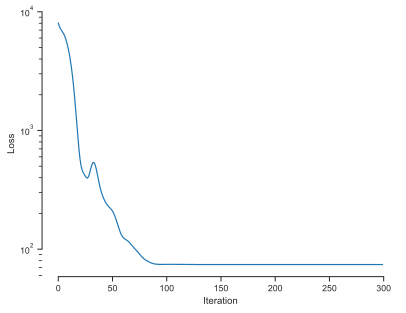

In [24]:
# Plot the loss evolution
fig, ax = plt.subplots()
ax.plot(loss_evol, color=colors[0])
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_yscale('log')
sns.despine(trim=True)
plt.show()

Looks like it has converged. Let's move to the calculate the covariance matrix for the laplace approximation. Unfortunately with the diffrax solver, calculating the hessian is not straightforward. We will use finite differences to approximate it at the MAP estimate.

In [25]:
def compute_post_cov(mu, y, sigma, gamma, z0, t, epsilon=1e-5):
    """Compute the posterior covariance matrix using the Hessian of the log-posterior."""    
    n = mu.size

    # Define the function f(mu) that computes the model outputs
    def f(x):
        sol = solve_catalysis(t, x, z0)
        f_mu = jnp.hstack([sol[:, :2], sol[:, 3:]]).flatten()
        return f_mu

    # Compute f(mu) at the given mu
    f_mu = f(mu)
    m = f_mu.size
    
    # Initialize gradient dfdx (Jacobian matrix)
    dfdx = jnp.zeros((m, n))

    # Compute gradient of our solver numerically using finite differences
    for i in range(n):
        e_i = jnp.zeros(n)
        e_i = e_i.at[i].set(epsilon)
        f_plus = f(mu + e_i)
        f_minus = f(mu - e_i)
        f_prime = (f_plus - f_minus) / (2 * epsilon)
        dfdx = dfdx.at[:, i].set(f_prime)

    # Initialize Hessian d2fdx2
    d2fdx2 = jnp.zeros((m, n, n))

    # Compute Hessian of our solver numerically using finite differences
    for i in range(n):
        for j in range(i, n):
            e_i = jnp.zeros(n)
            e_j = jnp.zeros(n)
            e_i = e_i.at[i].set(epsilon)
            e_j = e_j.at[j].set(epsilon)

            f_pp = f(mu + e_i + e_j)
            f_pm = f(mu + e_i - e_j)
            f_mp = f(mu - e_i + e_j)
            f_mm = f(mu - e_i - e_j)

            second_derivative = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon ** 2)

            # Assign the second derivative to the Hessian matrix with jax's at method
            d2fdx2 = d2fdx2.at[:, i, j].set(second_derivative)

    # Compute the second derivative of the log-posterior (d2Ldx2)
    tmp = y - f_mu
    sigma2_inv = 1.0 / sigma ** 2
    gamma2_inv = 1.0 / gamma ** 2

    # First term: - (1 / sigma^2) * sum_i (y_i - f_i) * d2f_i/dx^2
    term1 = - jnp.einsum('i,ijk->jk', tmp, d2fdx2) * sigma2_inv

    # Second term: (1 / sigma^2) * (df/dx)^T * (df/dx)
    term2 = (dfdx.T @ dfdx) * sigma2_inv

    # Third term: (1 / gamma^2) * Identity matrix
    term3 = jnp.eye(n) * gamma2_inv

    d2Ldx2 = term1 + term2 + term3

    # Add jitter for numerical stability
    jitter = 1e-6 * jnp.eye(n)

    # Compute the posterior covariance matrix
    cov = jnp.linalg.inv(d2Ldx2 + jitter)

    return cov

In [26]:
# Compute the posterior covariance
mu = x
Sigmas = compute_post_cov(mu, y, sigma, gamma, z0, t_exp)

Great, let's plot our samples.

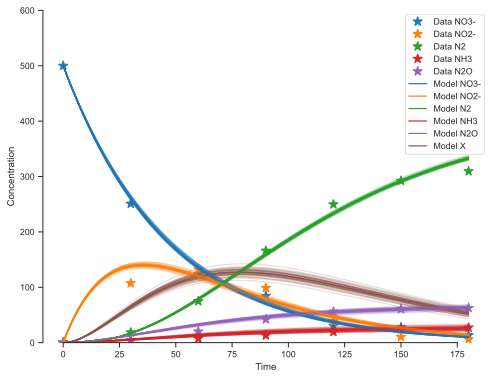

In [27]:
num_samples = 50
times = jnp.linspace(t0, t1, 1000)
key, subkey = jr.split(key)
samples = jax.random.multivariate_normal(key, mu, Sigmas, shape=(num_samples,))
# Compute the samples
sample_models = jnp.array([solve_catalysis(times, sample, z0) for sample in samples])

# Compute the median model
median_models = jnp.median(sample_models, axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define labels and colors
labels = ['NO3-', 'NO2-', 'N2', 'NH3', 'N2O', 'X']
data_cols = ['NO3', 'NO2', 'N2', 'NH3', 'N2O']
model_cols = [0, 1, 3, 4, 5, 2]

# Plot experimental data
for i, col in enumerate(data_cols):
    ax.plot(t_exp, catalysis_data[col], '*', color=colors[i], label=f'Data {labels[i]}', markersize=10)

# Plot the mean models
for i, col in enumerate(model_cols):
    ax.plot(times, median_models[:, col], color=colors[i], label=f'Model {labels[i]}')

# Plot the samples
for i in range(num_samples):
    for j, col in enumerate(model_cols):
        ax.plot(times, sample_models[i, :, col], color=colors[j], alpha=0.2)

# Add legend for the models and data
handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for label, handle in zip(labels, handles)}
ax.legend(unique_labels.values(), unique_labels.keys())
ax.set_ylim(0, 600)
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
sns.despine(trim=True)
plt.show()



### Questions
+ Investigate what happens as you go from a very large $\sigma$ (say $20$) to a very small one (say $1$.) Is there a sweet spot?

+ Investigate what happens as you change $\gamma$ in the same way.

+ How else can you propagate uncertainty through the solver?

## Estimating the Noise Level with the Laplace Approximation

We can estimate the noise level with the Laplace approximation.
We need a prior on $\sigma$.
Let's pick:

$$
p(\sigma) \propto \frac{1}{\sigma}.
$$

This is known as the [Jeffrey's prior](https://en.wikipedia.org/wiki/Jeffreys_prior).

Also, because of the nature of the parameterization, it probably makes sense to work with $\log \sigma$ instead of $\sigma$.
So, let's introduce the following unknown vector to be inferred from the data:

$$
z = (x, \theta),
$$

where

$$
\theta = \log\sigma.
$$

### Be careful when you change variables
We need to be a little bit careful with $p(\theta)$.
We need to use the [change of variables formula](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables).
Define:

$$
\theta := g(\sigma) = \log \sigma.
$$

The inverse is:
$$
g^{-1}(\theta) = e^{\theta}.
$$

The formula is:

$$
p(\theta) = \left|\frac{d}{d\theta}\left(g^{-1}(\theta)\right)\right|\cdot p(\sigma=e^{\theta}) \propto e^\theta e^{-\theta} = 1.
$$

So

$$
p(\theta) \propto 1.
$$

Now, we just derive the posterior of $z$:

$$
p(z|y) \propto p(y|z)p(z) \propto e^{-m\theta}\exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2e^{2\theta}}\right\}p(x),
$$

and we apply the Laplace approximation using:

$$
L(z) = -m\theta - \frac{\parallel y - f(x) \parallel_2^2}{2}e^{-2\theta} + \log p(x).
$$

The first and second mixed derivative with respect to $x$ are just like before.
We need the derivatives with respect to $\theta$:

$$
\frac{\partial L(z)}{\partial \theta} = -m + \parallel y - f(x) \parallel_2^2e^{-2\theta},
$$

$$
\frac{\partial^2 L(z)}{\partial \theta^2} = -2\parallel y - f(x) \parallel_2^2e^{-2\theta},
$$

and

$$
\frac{\partial^2 L(z)}{\partial x_j\partial\theta} = 2e^{-2\theta}\sum_{i=1}^m(y_i-f_i(x))\frac{\partial f_i(x)}{\partial x_j}.
$$

So the log posterior will look largely the same as the previous case, but with another prior on $\theta$.

In [28]:
# Negative log posterior and its gradient
def post_w_noise(params, z, y, t, gamma):

    m = y.shape[0]

    # Extract theta from our optimized parameters
    theta = params[-1] 
    # Exponential of theta is the noise
    sigma = jnp.exp(theta)

    # Extract the parameters to solve the ODE
    x = params[:-1]

    res = solve_catalysis(t, x, z)
    flat_res = jnp.hstack([res[:, :2], res[:, 3:]]).flatten()
    
    # Negative log-likelihood
    tmp = (flat_res - y) 
    likelihood = 0.5 * jnp.sum(tmp**2) / sigma** 2
    
    # Negative log-prior
    prior = 0.5 * jnp.sum(x**2) / gamma**2

    # Negative log-prior for the noise
    prior_noise = theta * m
    
    # Total negative log posterior
    posterior = likelihood + prior + prior_noise
    
    return posterior

Optimize again like we did before. notice how we have grouped the things we are optimizing together in `params`. This is nice because we can take the gradient of the log posterior with respect to this vector and pass it to the optimizer.

In [29]:
# Initial guess for x
key = jr.PRNGKey(0)
x0 = jr.normal(key, shape=(6,))  

# Initial conditions
z0 = jnp.array([500., 0., 0., 0., 0., 0.0])

# Extract the experimental data
Y = catalysis_data.values
y = Y.flatten()

# Initialize the noise parameter
sigma0 = 5.0
theta0 = jnp.log(sigma0)
gamma = 10.0

# Concatenate the parameters
params0 = jnp.hstack([x0, theta0])

# Set up the optimizer
optimizer = optax.adam(learning_rate=1e-1)
opt_state = optimizer.init(params0)

# Use as many iterations as needed
num_iterations = 300
loss_noise = []
params = params0 

for i in range(num_iterations):
    
    value, grads = value_and_grad(post_w_noise)(params, z0, y, t_exp, gamma)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_noise.append(value)
        # Print the loss every 100 iterations
    if i % 50 == 0:
        print(f"Iteration {i}, loss: {value}")

post_params = params
mu_noise = params[:-1]
post_theta = params[-1]
mean_post_sigma = jnp.exp(post_theta)

Iteration 0, loss: 8113.783495204607
Iteration 50, loss: 127.85475747340736
Iteration 100, loss: 122.05862131332408
Iteration 150, loss: 119.35589901543382
Iteration 200, loss: 116.08262519412267
Iteration 250, loss: 112.82457215665802


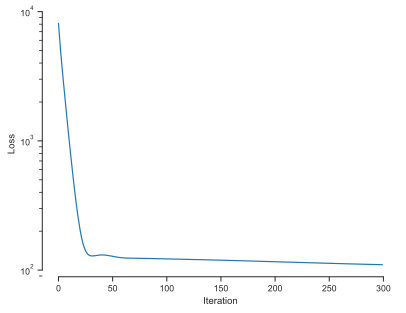

In [30]:
# Plot the loss evolution
fig, ax = plt.subplots()
ax.plot(loss_noise, color=colors[0])
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_yscale('log')
sns.despine(trim=True)
plt.show()

Alright, looking good. Now we will make some similar edits to the covariance calculation.

In [31]:
def compute_post_cov_w_noise(mu, y, gamma, z0, t, epsilon=1e-5):
    """Compute the posterior covariance matrix using the Hessian of the log-posterior."""

    n = mu.size - 1  # Number of model parameters x
    x = mu[:n]
    theta = mu[n]
    sigma = jnp.exp(theta)
    sigma2_inv = 1.0 / sigma ** 2

    # Define the function f(x) that computes the model outputs
    def f(x):
        sol = solve_catalysis(t, x, z0)
        f_x = jnp.hstack([sol[:, :2], sol[:, 3:]]).flatten()
        return f_x

    # Compute f(x) at the given x
    f_mu = f(x)
    m = f_mu.size

    # Compute tmp = y - f_mu
    tmp = y - f_mu

    # Compute gradient dfdx (Jacobian matrix), shape (m, n)
    # Use JAX's vmap to vectorize the computation over parameters
    def compute_dfdx_i(i):
        e_i = jnp.zeros_like(x)
        e_i = e_i.at[i].set(epsilon)
        f_plus = f(x + e_i)
        f_minus = f(x - e_i)
        f_prime = (f_plus - f_minus) / (2 * epsilon)
        return f_prime  # Shape: (m,)

    indices = jnp.arange(n)
    dfdx = jax.vmap(compute_dfdx_i)(indices)  # Shape: (n, m)
    dfdx = dfdx.T  # Transpose to shape (m, n)

    # Compute Hessian d2fdx2, shape (m, n, n)
    # We will compute only the upper triangle and exploit symmetry
    def compute_d2fdx2_ij(i, j):
        e_i = jnp.zeros_like(x)
        e_j = jnp.zeros_like(x)
        e_i = e_i.at[i].set(epsilon)
        e_j = e_j.at[j].set(epsilon)

        f_pp = f(x + e_i + e_j)
        f_pm = f(x + e_i - e_j)
        f_mp = f(x - e_i + e_j)
        f_mm = f(x - e_i - e_j)

        second_derivative = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon ** 2)
        return second_derivative  # Shape: (m,)

    # Generate all index pairs (i, j) with i <= j
    index_pairs = [(i, j) for i in range(n) for j in range(i, n)]
    num_pairs = len(index_pairs)

    # Vectorize over index pairs
    i_indices = jnp.array([pair[0] for pair in index_pairs])
    j_indices = jnp.array([pair[1] for pair in index_pairs])

    d2fdx2_values = jax.vmap(compute_d2fdx2_ij)(i_indices, j_indices)  # Shape: (num_pairs, m)

    # Initialize Hessian tensor
    d2fdx2 = jnp.zeros((m, n, n), dtype=jnp.float64)

    # Populate d2fdx2 using immutable updates
    for idx in range(num_pairs):
        i = i_indices[idx]
        j = j_indices[idx]
        second_derivative = d2fdx2_values[idx]  # Shape: (m,)
        d2fdx2 = d2fdx2.at[:, i, j].set(second_derivative)
        if i != j:
            d2fdx2 = d2fdx2.at[:, j, i].set(second_derivative)  # Exploit symmetry

    # Compute the components of the Hessian matrix

    # Term1: -sigma2_inv * sum_i tmp_i * d2f_i/dx^2
    term1 = - sigma2_inv * jnp.einsum('i,ijk->jk', tmp, d2fdx2)  # Shape: (n, n)

    # Term2: sigma2_inv * (dfdx.T @ dfdx)
    term2 = sigma2_inv * (dfdx.T @ dfdx)  # Shape: (n, n)

    # Compute d2Ldx2
    d2Ldx2 = term1 + term2 + jnp.eye(n) / gamma ** 2  # Shape: (n, n)

    # Compute d2Ldxdtheta: 2 * sigma2_inv * (dfdx.T @ tmp)
    d2Ldxdtheta = 2 * sigma2_inv * (dfdx.T @ tmp)  # Shape: (n,)

    # Compute d2Ldtheta2: 2 * sigma2_inv * (tmp.T @ tmp)
    d2Ldtheta2 = 2 * sigma2_inv * (tmp.T @ tmp)  # Scalar

    # Assemble the Hessian matrix Lam, shape (n + 1, n + 1)
    Lam = jnp.zeros((n+1, n+1), dtype=jnp.float64)
    Lam = Lam.at[:n, :n].set(d2Ldx2)
    Lam = Lam.at[:n, n].set(d2Ldxdtheta)
    Lam = Lam.at[n, :n].set(d2Ldxdtheta)
    Lam = Lam.at[n, n].set(d2Ldtheta2)

    # Add jitter for numerical stability
    jitter = 1e-6 * jnp.eye(n + 1)
    Lam = Lam + jitter

    # Compute the posterior covariance matrix
    Sigma = jnp.linalg.inv(Lam)

    return Sigma


Let's plot our results.

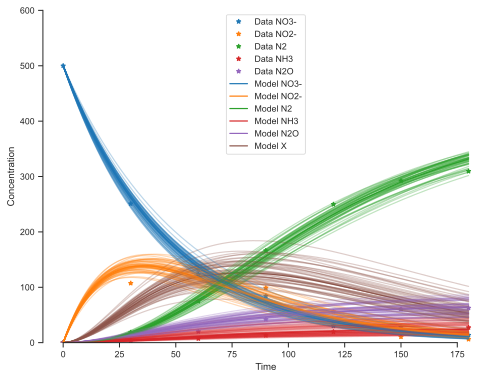

In [34]:
# Compute the posterior covariance with noise
Sigmas_noise = compute_post_cov_w_noise(post_params, y, gamma, z0, t_exp)

num_samples_noise = 50
times_noise = jnp.linspace(t0, t1, 1000)
key, subkey = jr.split(key)
samples_noise = jax.random.multivariate_normal(key, mu, Sigmas_noise[:-1, :-1], shape=(num_samples_noise,))

# Compute the samples with noise
sample_models_noise = jnp.array([solve_catalysis(times_noise, sample[:-1], z0) for sample in samples_noise])

# Compute the median model with noise
median_models_noise = jnp.median(sample_models_noise, axis=0)

# Plotting with noise
fig, ax = plt.subplots(figsize=(8, 6))

# Define labels and colors
labels = ['NO3-', 'NO2-', 'N2', 'NH3', 'N2O', 'X']
data_cols = ['NO3', 'NO2', 'N2', 'NH3', 'N2O']
model_cols = [0, 1, 3, 4, 5, 2]

# Plot experimental data
for i, col in enumerate(data_cols):
    ax.plot(t_exp, catalysis_data[col], '*', color=colors[i], label=f'Data {labels[i]}')

# Plot the mean models with noise
for i, col in enumerate(model_cols):
    ax.plot(times_noise, median_models_noise[:, col], color=colors[i], label=f'Model {labels[i]}')

for i in range(num_samples_noise):
    for j, col in enumerate(model_cols):
        ax.plot(times_noise, sample_models_noise[i, :, col], color=colors[j], alpha=0.3)
ax.set_ylim(0, 600)
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
plt.legend()
sns.despine(trim=True)
plt.show()


In [33]:
var_post_sigma = jnp.sqrt(jnp.diag(Sigmas)[-1])

print(f'The mean noise level is {mean_post_sigma} and the variance is {var_post_sigma}')

The mean noise level is 20.379103367005346 and the variance is 9.999500037496876


### Questions
+ Investigate what happens as you change $\gamma$ from smaller to bigger values.

+ Is the uncertainty we visualized above epistemic or aleatory?

+ The uncertainty visualized concerns only the model. What if you wanted to include the measurement noise in this visualization?

+ The assumption of Gaussian noise is not very good. Generate two different assumptions that you could try for the noise.